In [33]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from binance.client import Client
import pymongo

import pandas as pd
import numpy as np


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

with open('./binance-secrets.txt', 'r') as file:
    content = file.read()
    apiKey = content.split()[2]
    secret = content.split()[5]

In [5]:
myclient = pymongo.MongoClient("mongodb://192.168.5.103:27017/")
mydb = myclient["crypto_db"]

In [6]:
iota_data = pd.DataFrame(list(mydb['IOTA'].find()))
iota_data.head()

,Close,Close Time,High,Ignore,Low,Number of trades,Open,Open Time,Quote asset volume,Taker buy base asset volume,Taker buy quote asset volume,Volume,_id
0,1.8300,2018-05-31 05:30:59,2.1500,0,1.4000,24.0,1.4000,2018-05-31 05:30:00,6513.121094,2005.390015,3977.53910000,3519.520020,5ce1bee839129f2f63003618
1,1.7012,2018-05-31 05:31:59,1.9900,0,1.6900,17.0,1.8300,2018-05-31 05:31:00,8517.683594,3179.429932,5864.78411000,4742.939941,5ce1bee839129f2f63003619
2,1.7213,2018-05-31 05:32:59,1.7887,0,1.7202,5.0,1.7887,2018-05-31 05:32:00,228.559540,129.639999,226.82108800,130.649994,5ce1bee839129f2f6300361a
3,1.7480,2018-05-31 05:33:59,1.7490,0,1.7230,21.0,1.7490,2018-05-31 05:33:00,6794.635254,1154.869995,2015.93968900,3889.489990,5ce1bee839129f2f6300361b
4,1.7301,2018-05-31 05:34:59,1.7479,0,1.7263,16.0,1.7479,2018-05-31 05:34:00,2139.148682,352.500000,615.62603200,1233.300049,5ce1bee839129f2f6300361c


In [7]:
iota_data = iota_data[['Close', 'Close Time', 'High', 'Low', 'Number of trades', 'Volume']]
iota = iota_data[iota_data['Close Time'] > '2019-04-01 00:00:00.000'][['Close']]
iota['Close'] = iota['Close'].astype(float)

In [8]:
iota['Close'].values.reshape(-1, 1)

array([[0.31110001],
       [0.31099999],
       [0.3105    ],
       ...,
       [0.40290001],
       [0.40369999],
       [0.40329999]])

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
iota['Close'] = scaler.fit_transform(iota['Close'].values.reshape(-1, 1))

In [10]:
for i in range(-1, -31, -1):
    column_name = f'Close_{i*-1}'
    iota[column_name] = iota['Close'].shift(i)

In [11]:
iota.dropna(inplace=True)

iota.head()

,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Close_21,Close_22,Close_23,Close_24,Close_25,Close_26,Close_27,Close_28,Close_29,Close_30
436718,0.312640,0.312193,0.309960,0.309960,0.309960,0.307727,0.308173,0.308173,0.308173,0.309513,...,0.316213,0.315766,0.315766,0.315766,0.315766,0.316213,0.316213,0.312193,0.312193,0.311746
436719,0.312193,0.309960,0.309960,0.309960,0.307727,0.308173,0.308173,0.308173,0.309513,0.309513,...,0.315766,0.315766,0.315766,0.315766,0.316213,0.316213,0.312193,0.312193,0.311746,0.310853
436720,0.309960,0.309960,0.309960,0.307727,0.308173,0.308173,0.308173,0.309513,0.309513,0.309513,...,0.315766,0.315766,0.315766,0.316213,0.316213,0.312193,0.312193,0.311746,0.310853,0.312640
436721,0.309960,0.309960,0.307727,0.308173,0.308173,0.308173,0.309513,0.309513,0.309513,0.312640,...,0.315766,0.315766,0.316213,0.316213,0.312193,0.312193,0.311746,0.310853,0.312640,0.314873
436722,0.309960,0.307727,0.308173,0.308173,0.308173,0.309513,0.309513,0.309513,0.312640,0.311746,...,0.315766,0.316213,0.316213,0.312193,0.312193,0.311746,0.310853,0.312640,0.314873,0.315766


In [12]:
X = iota.drop('Close', axis=1)
y = iota['Close']

In [22]:
total = len(iota)
test_size = 60*12
perc = round(((total-test_size)/total)*100, 4)

In [23]:
X_dataloader = DataLoader(X, batch_size=30,
                        shuffle=False, num_workers=4)

In [24]:
y_dataloader = DataLoader(y, batch_size=30,
                         shuffle=False, num_workers=4)

In [25]:
print(f'Using {total-test_size} samples ({perc}%) to forecast the next {test_size} minutes')
X_train = X_dataloader.dataset[:-test_size]
X_test = X_dataloader.dataset[-test_size:]

y_train = y_dataloader.dataset[:-test_size]
y_test = y_dataloader.dataset[-test_size:]

print(f'X_train: {len(X_train)}\ny_train: {len(y_train)}\nX_test: {len(X_test)}\ny_test: {len(y_test)}\n')

Using 79164 samples (99.0987%) to forecast the next 720 minutes
X_train: 79164
y_train: 79164
X_test: 720
y_test: 720



# XGBRegressor

In [115]:
xgb = XGBRegressor()

In [116]:
xgb.fit(X_train, y_train)

c:\users\altoz_aaxmwbk\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

c:\users\altoz_aaxmwbk\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [117]:
preds = xgb.predict(X_test)

mae = mean_absolute_error(preds, y_test)
rmse = np.sqrt(mean_squared_error(preds, y_test))
r2 = r2_score(preds, y_test)
print('Scaled:\n\n')
print(f'MAE: {mae} | RMSE: {rmse} | R^2: {r2}')

Scaled:


MAE: 0.002102506492726251 | RMSE: 0.0021151760211074472 | R^2: -6.3107912338462295


In [118]:
preds = scaler.inverse_transform(preds.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1))

In [119]:
mae = mean_absolute_error(preds, y_test)
rmse = np.sqrt(mean_squared_error(preds, y_test))
r2 = r2_score(preds, y_test)
print('Unscaled:\n\n')
print(f'MAE: {mae} | RMSE: {rmse} | R^2: {r2}')

Unscaled:


MAE: 0.0038011163473129273 | RMSE: 0.0038240216065750974 | R^2: -6.310783419469592


In [120]:
trace = go.Scatter(
    x = [i[0] for i in y_test],
    y = [i[0] for i in preds],
    name = 'Predictions'
)
layout = go.Layout(title='Predictions vs Actuals')
fig = go.Figure([trace], layout)
iplot(fig)

# PyTorch

In [94]:
class pyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, output_size=1, num_layers=2):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size, 
                            num_layers=self.num_layers
                           )
        
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
    
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        
        # Need to integrate a DataLoader so I can utilize different batch sizes
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction

        y_pred = self.linear(lstm_out.view(self.batch_size, -1))
        return y_pred.view(-1)



In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [96]:
batch_size = 1
inputs = 30

model = pyLSTM(input_size=inputs, hidden_size=inputs, batch_size=batch_size, num_layers=1)#.to(device)
model

pyLSTM(
  (lstm): LSTM(30, 30)
  (dropout1): Dropout(p=0.5)
  (linear): Linear(in_features=30, out_features=1, bias=True)
)

In [97]:
train_X = torch.from_numpy(X_train.values)#.to(device)
train_y = torch.from_numpy(y_train.values)#.to(device)
test_X = torch.from_numpy(X_test.values)#.to(device)
test_y = torch.from_numpy(y_test.values)#.to(device)

In [98]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train.values), torch.from_numpy(y_train.values))
test_data = TensorDataset(torch.from_numpy(X_test.values), torch.from_numpy(y_test.values))


# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [ ]:
learning_rate = 0.001
num_epochs = 40

model.train()

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

#####################
# Train model
#####################

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    
    for train, label in train_loader:
        # Clear stored gradient
        model.zero_grad()

        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        model.hidden = model.init_hidden()

        # Forward pass
        y_pred = model(train.float())

        loss = loss_fn(y_pred, label.float())
        
        #print(f'EPOCH: {t} | MSE: {loss.item()}')
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
    print(f'EPOCH: {t} | MSE: {loss.item()}')

In [92]:
torch.save(model.state_dict(), './models/pytorch_model.pt')

In [436]:
model.forward(test_X)

RuntimeError: shape '[22, 32, 30]' is invalid for input of size 21600

In [432]:
test_X.shape

torch.Size([720, 30])

In [430]:
pypreds = model.forward(test_X.float()).detach().numpy()

RuntimeError: shape '[22, 32, 30]' is invalid for input of size 21600

In [417]:
actuals = go.Scatter(
    x = [i for i in range(len(y_test))],
    y = y_test.values,
    name='Actuals'
)

keras = go.Scatter(
    x = [i for i in range(len(preds))],
    y = preds,
    name='Keras'
)

pytorch = go.Scatter(
    x = [i for i in range(len(preds))],
    y = [i for i in pypreds],
    name='pytorch'
)

layout = go.Layout(title='Keras vs PyTorch')
fig = go.Figure([actuals, keras, pytorch], layout)
iplot(fig)

In [406]:
import matplotlib.pyplot as plt
%matplotlib inline

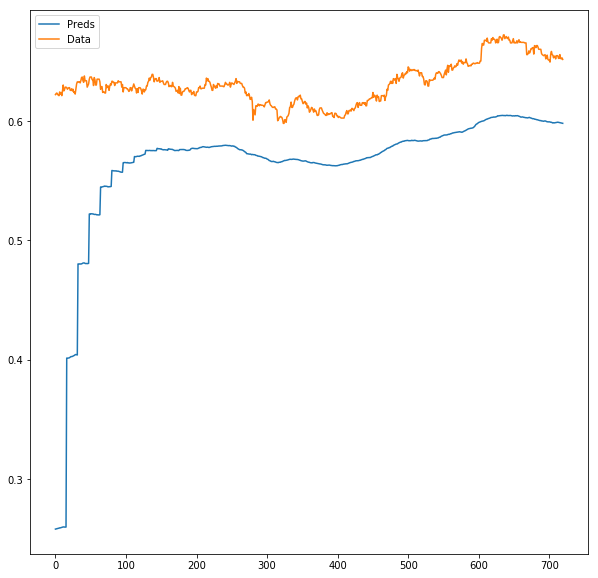

In [407]:
plt.figure(figsize=(10,10))
plt.plot(pypreds, label="Preds")
plt.plot(test_y.detach().numpy(), label="Data")
plt.legend()
plt.show()

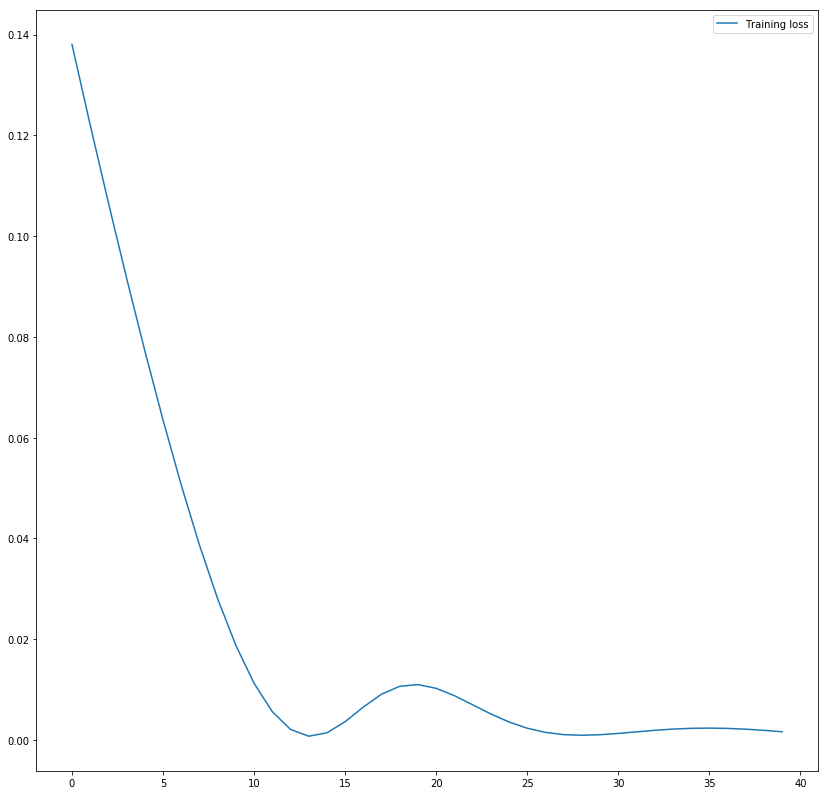

In [408]:
plt.figure(figsize=(14, 14))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

# Keras

In [27]:
from keras.layers import LSTM, Dense, Dropout, ReLU, CuDNNLSTM
from keras.models import Sequential

Using TensorFlow backend.


In [452]:
kX_train = X_train.values.reshape(X_train.values.shape[0], 1, X_train.values.shape[1])
kX_test = X_test.values.reshape(X_test.values.shape[0], 1, X_test.values.shape[1])
kY_train = y_train.values
kY_test = y_test.values


kX = X.values.reshape(X.values.shape[0], 1, X.values.shape[1])
kY = y.values

In [453]:
kmodel = Sequential()
kmodel.add(LSTM(120))
kmodel.add(Dropout(0.5))
kmodel.add(Dense(1))

kmodel.compile(loss='mean_squared_error', optimizer='adam')

history = kmodel.fit(kX_train, kY_train, batch_size=30, epochs=10, validation_data=(kX_test, kY_test))

Train on 76960 samples, validate on 720 samples
Epoch 1/10
76960/76960 [==============================] - 42s 545us/step - loss: 0.0017 - val_loss: 1.6553e-04 -  -  - ET - ETA: 0s - lo
Epoch 2/10
76960/76960 [==============================] - 40s 523us/step - loss: 5.7980e-04 - val_loss: 1.5300e-04E - ETA: 16s - loss: 6.4730 - E - ETA:  - - ETA: 12s - loss
Epoch 3/10
76960/76960 [==============================] - 40s 525us/step - loss: 4.7150e-04 - val_loss: 1.1017e-04
Epoch 4/10
76960/76960 [==============================] - 40s 523us/step - loss: 4.5111e-04 - val_loss: 6.1295e-05- loss: 4.5255 -  - ETA: 0s - loss: 4.5117e-0
Epoch 5/10
76960/76960 [==============================] - 40s 520us/step - loss: 4.3268e-04 - val_loss: 1.0980e-05e - ETA: 5s - loss: 4.36 - ETA: 5s - l - ETA: 4s - loss: -  - ETA: 0s - loss: 4.3255e-
Epoch 6/10
76960/76960 [==============================] - 40s 521us/step - loss: 4.3315e-04 - val_loss: 2.2356e-05 - lo - ETA: 5s - l - ETA - ETA: 3s - l - ETA: 2s -

In [454]:
loss = go.Scatter(
    x = history.epoch,
    y = history.history['loss'],
    name='Loss'
)

val_loss = go.Scatter(
    x = history.epoch,
    y = history.history['val_loss'],
    name='Val_Loss'
)

layout = go.Layout(title='Training | Keras')
fig = go.Figure([loss, val_loss], layout)
iplot(fig)

In [455]:
residuals = preds - y_test

In [456]:
forecast = go.Scatter(
    x = [i for i in range(len(preds))],
    y = residuals,
    name='Residuals'
)

layout = go.Layout(title='Residuals | Keras')
fig = go.Figure([forecast], layout)
iplot(fig)

In [457]:
preds = [i[0] for i in kmodel.predict(kX_test)]

In [458]:
actuals = go.Scatter(
    x = [i for i in range(len(y_test))],
    y = y_test.values,
    name='Actuals'
)

forecast = go.Scatter(
    x = [i for i in range(len(preds))],
    y = preds,
    name='Predictions'
)

layout = go.Layout(title='Forecast vs Actuals | Keras')
fig = go.Figure([actuals, forecast], layout)
iplot(fig)

In [459]:
kmodel.save('./models/keras_model.h5')